<p align="center">
    <img src="https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2018/02/pytorch-logo-flat-300x210.png">
</p>

다양한 딥러닝 프레임워크가 있지만 오늘은 파이토치를 CIFAR-10 데이터셋에 이용해 간단한 MLP를 실습해보겠습니다.

파이토치는 파이썬에서 그냥 `torch` 라는 이름으로 불러올 수 있습니다.

구글 콜랩에 기본적으로 설치가 안되어있을수도 있으니 먼저 설치해줄게요

In [2]:
!pip install torch  # Requirement already satisfied 라고 뜨는걸 보니 요즘엔 기본적으로 깔려오는가 보네요
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz  # CIFAR-10 데이터를 받아옵니다
!tar -xvzf cifar-10-python.tar.gz  # 압축을 풀어줄게요

--2019-02-12 07:06:14--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  5.41MB/s    in 18s     

2019-02-12 07:06:32 (9.16 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [3]:
!ls

cifar-10-batches-py  cifar-10-python.tar.gz  sample_data


In [4]:
!ls -l cifar-10-batches-py  # 구조를 한번 볼게요. data_batch_x가 5개 있는데 데이터 설명에 의하면 피클링된 딕셔너리라고 합니다.

total 181876
-rw-r--r-- 1 2156 1103      158 Mar 31  2009 batches.meta
-rw-r--r-- 1 2156 1103 31035704 Mar 31  2009 data_batch_1
-rw-r--r-- 1 2156 1103 31035320 Mar 31  2009 data_batch_2
-rw-r--r-- 1 2156 1103 31035999 Mar 31  2009 data_batch_3
-rw-r--r-- 1 2156 1103 31035696 Mar 31  2009 data_batch_4
-rw-r--r-- 1 2156 1103 31035623 Mar 31  2009 data_batch_5
-rw-r--r-- 1 2156 1103       88 Jun  4  2009 readme.html
-rw-r--r-- 1 2156 1103 31035526 Mar 31  2009 test_batch


## Data Loader

In [0]:
# 그럼 unpickling을 할 수 있도록 함수를 짜줍시다

import pickle, os

def unpickle(fpath):
    with open(fpath, 'rb') as f:
        data = pickle.load(f, encoding='bytes')
    return data

In [0]:
import torch
from torch import nn
import numpy as np

base_path = 'cifar-10-batches-py'
fname = 'data_batch_1'  # 튜토리얼이니 간단하게 1번 데이터셋만 써봅시다

fpath = os.path.join(base_path, fname)
dict_ = unpickle(fpath)

In [7]:
dict_.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [8]:
X_train = dict_[b'data']
y_list  = dict_[b'labels']

n_row, n_dim = X_train.shape
n_cls = 10

y_true  = np.zeros((n_row, n_cls), dtype=np.uint8)
y_true[np.arange(n_row), y_list] = 1


print('X_train.shape: ', X_train.shape)
print('y_true.shape:  ', y_true.shape)

X_train.shape:  (10000, 3072)
y_true.shape:   (10000, 10)


In [9]:
# 제대로 됐는지 확인
y_true[:5]

array([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8)

In [0]:
# 데이터 10000개에 대해 매번 경사를 구하기는 힘드니, 미니배치를 사용할 수 있게 함수를 짜줍니다

def minibatch(X, y, size):
    nrow = X.shape[0]
    idx = np.random.choice(np.arange(nrow), size)
    return X[idx], y[idx]

## (아주 간단한) 시각화

label: [0 0 0 0 0 0 0 0 0 1]


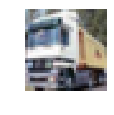

In [7]:
import matplotlib.pyplot as plt

idx = 1  # 시각화하려는 데이터 번호
img = X_train[idx].reshape([3,32,32]).transpose([1,2,0])
label = y_true[idx]

print('label:', label)
plt.figure(figsize=(1.5,1.5))
plt.axis('off')
plt.imshow(img)

## 모델링

```
# 기본 골자
class MyModel(torch.nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        pass
    
    def forward(self, x):
        return x
```

In [0]:
# https://pytorch.org/docs/stable/nn.html#linear-layers

class LinearClassifier(nn.Module):
    def __init__(self, n_in, n_out):
        super(LinearClassifier, self).__init__()
        self.layer = nn.Linear(n_in, n_out)  # W가 랜덤으로 생성됨
    
    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32)
        x = self.layer(x)
        return x

In [0]:
model = LinearClassifier(n_dim, n_cls)

In [0]:
X_batch, y_batch = minibatch(X_train, y_true, 4)

In [17]:
output = model(X_batch)
print('Output shape:', output.shape)
print('Actual output:\n', output)  # raw class score를 logit이라고도 부릅니다. 얘네를 exponentiate 한 후 비율을 구하면 softmax의 아웃풋이 됩니다.
print('Predicted labels:', output.argmax(dim=1))
print('True labels:     ', np.argmax(y_batch, axis=1))

Output shape: torch.Size([4, 10])
Actual output:
 tensor([[ -37.1305,   59.7090,   34.6117,   17.4214,  -65.5523,   85.8139,
          -31.1532,   59.8931,   59.7251,  -95.2393],
        [  21.1037,  104.3964,   89.4687,   53.3366,  -36.9933,   78.6085,
          -75.7398,   63.4855,   54.6945,  -97.7436],
        [ -41.9172,   77.1968,  -10.9243,   10.4547,   -6.6623,    3.9538,
          -98.5574,   31.5553,  -26.6848, -150.1195],
        [ -17.7222,   42.6076,   49.5088,  -19.9929,  -28.9665,   27.0795,
           -7.9767,    5.3331,   35.8892,  -81.9889]], grad_fn=<AddmmBackward>)
Predicted labels: tensor([5, 1, 1, 2])
True labels:      [4 0 5 2]


## Defining Optimizer

발표에서는 backprop을 통해 W에 대한 경사를 구하고, 그 경사를 다시 W에 적용해야 한다고 말씀드렸는데, 대부분의 딥러닝 프레임워크들은 이 과정을 옵티마이저라는 클래스를 통해 아주 간단하게 구현할 수 있도록 기능을 제공하고 있습니다.

In [0]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

## Defining Loss

Forward inference는 간단하게 되도록 짰습니다. 하지만 아직 Linear 레이어의 가중치들 (W)이 랜덤으로 생성돼서 그런지 예측값들이 영 별로네요.

이제는 Loss를 정의하고 Loss를 W에 대해 경사를 구한 후, 경사를 바탕으로 W를 업데이트 하는 과정을 짜보겠습니다

In [0]:
criterion = nn.BCEWithLogitsLoss()
loss = criterion(output, torch.tensor(y_batch, dtype=torch.float32))

In [0]:
optimizer.zero_grad()
loss.backward()
optimizer.step()

![alt text](http://cs231n.github.io/assets/stepsize.jpg)

위 코드에서 `step()`을 한번 하면, 사진에서 화살표 방향으로 조금 움직인거라 생각하시면 됩니다.

파란지점이 loss가 최소화되는 지점이라 생각하면, 이번 한번의 `step()`으로는 아직 갈길이 멀죠.

따라서 딥러닝을 할때는 아래의 과정을 루프로 돌리며 계속 계산을 하게 됩니다.

1. 미니배치를 뽑음
2. score 계산
3. loss 계산
4. loss를 W에 대해 backprop
5. `optimizer.step()`

## 루프로 돌려보자

In [0]:
n_steps = 10000
batch_size = 64

for i in range(n_steps):
    X_batch, y_batch = minibatch(X_train, y_true, batch_size)
    output = model(X_batch)
    loss = criterion(output, torch.tensor(y_batch, dtype=torch.float32))
    if i % 500 == 0:
        print(f'Step [{i} / {n_steps}] | loss: {loss}')
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [0]:
sample_X, sample_y = minibatch(X_train, y_true, 1)

label: [9]


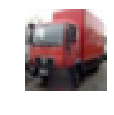

In [21]:
img = sample_X.reshape(3,32,32).transpose([1,2,0])
print('label:', sample_y.argmax(axis=1))
plt.figure(figsize=(1.5,1.5))
plt.axis('off')
plt.imshow(img)

In [22]:
model(sample_X)

tensor([[ -677.8120,  -742.8472, -1987.2703,   259.4281,  -737.1789, -1394.9772,
         -2199.3174,  -124.6948,  -693.7646,   408.6739]],
       grad_fn=<AddmmBackward>)

## Checking accuracy

In [57]:
total = model(X_train)
pred = total.argmax(dim=1).numpy()
(np.array(y_list) - pred == 0).sum() / n_row  # accuracy on train set

0.2255


# MLP

In [0]:
class MLP(nn.Module):
    def __init__(self, n_in, n_out):
        super(MLP, self).__init__()
        self.h = 400  # number of hidden units
        
        # ------ TODO: define three nn.Linear layers ------- #
        #                                                    #
        #                                                    #
        # -------------------------------------------------- #
        
        # ---------- TODO: define a ReLU function ---------- #
        #                                                    #
        #                                                    #
        # -------------------------------------------------- #

        
    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32).to(device)
            
        # --- TODO: forward propagate through the layers --- #
        #                                                    #
        #                                                    #
        # -------------------------------------------------- #
        
        return x

In [0]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = MLP(n_dim, n_cls).to(device)  # device가 지금은 'cuda'라서 GPU에서 돌아요!

In [0]:
# https://pytorch.org/docs/stable/optim.html  여기 참고해서 어떤 옵티마이저가 있는지 한번 확인해보세요!
optimizer = pass # define optimizer

In [0]:
# https://pytorch.org/docs/stable/nn.html#loss-functions  여기에서 loss function들은 어떻게 있는지 확인해보세요!
criterion = nn.BCEWithLogitsLoss()

In [73]:
n_steps = 30000
batch_size = 64

for i in range(n_steps):
    X_batch, y_batch = minibatch(X_train, y_true, batch_size)
    output = model(X_batch)
    loss = criterion(output, torch.tensor(y_batch, dtype=torch.float32).to(device))
    if i % 500 == 0:
        print(f'Step [{i} / {n_steps}] | loss: {loss}')
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Step [0 / 30000] | loss: 0.19526973366737366
Step [500 / 30000] | loss: 0.14716064929962158
Step [1000 / 30000] | loss: 0.15943506360054016
Step [1500 / 30000] | loss: 0.16370323300361633
Step [2000 / 30000] | loss: 0.16242757439613342
Step [2500 / 30000] | loss: 0.16038461029529572
Step [3000 / 30000] | loss: 0.13436144590377808
Step [3500 / 30000] | loss: 0.1369234323501587
Step [4000 / 30000] | loss: 0.16454572975635529
Step [4500 / 30000] | loss: 0.14131863415241241
Step [5000 / 30000] | loss: 0.11575169861316681
Step [5500 / 30000] | loss: 0.13749276101589203
Step [6000 / 30000] | loss: 0.16824816167354584
Step [6500 / 30000] | loss: 0.1504296213388443
Step [7000 / 30000] | loss: 0.14504443109035492
Step [7500 / 30000] | loss: 0.1387624442577362
Step [8000 / 30000] | loss: 0.14606936275959015
Step [8500 / 30000] | loss: 0.13666744530200958
Step [9000 / 30000] | loss: 0.17618730664253235
Step [9500 / 30000] | loss: 0.14012610912322998
Step [10000 / 30000] | loss: 0.1579869836568832

In [74]:
total = model(X_train)
pred = total.argmax(dim=1).cpu().numpy()
(np.array(y_list) - pred == 0).sum() / n_row  # accuracy on train set

0.8089

### On test set

In [0]:
data_ = unpickle(os.path.join(base_path,'test_batch'))
X_test = data_[b'data']
y_test = np.array(data_[b'labels'])

In [82]:
total = model(X_test)
pred = total.argmax(dim=1).cpu().numpy()
(y_test - pred == 0).sum() / X_test.shape[0]  # accuracy on train set

0.4201